# Задача 12 (бонусная). Экспериментальное исследование алгоритмов решения задачи достижимости с КС ограничениями

## Подготовка окружения

Для исполнения кода, приведённого в данном исследовании, необходима система с ядром Linux, подготовленная при помощи выполнения команд, приведённых далее.

In [ ]:
# @formatter:off
! pip install -r ../requirements.txt
! pip install pycubool matplotlib seaborn
# @formatter:on

In [182]:
import importlib.util
import pathlib
import sys

# Add repository directory to path if needed
if importlib.util.find_spec("project") is None:
    sys.path.append(str(pathlib.Path.cwd().parent))

## Введение

В данной работе рассматривается задача достижимости в графе с контекстно-свободными ограничениями: исследуется производительность нескольких алгоритмов её решения, основанных на линейной алгебре, а также проводится их сравнение с решением схожей задачи, но при регулярных ограничениях. Алгоритмы реализованы на языке Python так, что матричные операции осуществляются на CUDA-ядрах GPU при помощи библиотеки [**pycubool**](https://github.com/JetBrains-Research/cuBool).

### О задаче достижимости

Задача достижимости ставится следующим образом. Пусть дан конечный ориентированный помеченный граф $G = (V, E, L)$, в котором каждому пути $\pi \in E^*$, состоящему из рёбер с метками $l_1, ..., l_n \in L$, сопоставляется слово по правилу $\omega(\pi) = l_1 * ... * l_n$, где $*$ --- конкатенация. Пусть также дана контекстно-свободная грамматика $C$, задающая язык над алфавитом $L$. Требуется найти такие пары вершин $G$, что между ними существует путь, которому сопоставляется слово из языка, задаваемого $C$. То есть задача заключается в нахождении множества $\{(v_i, v_j) \in V^2: \exists \pi \in E^*: start(\pi) = v_i, final(\pi) = v_j, \omega(\pi) \in language(C)\}$.

### Исследуемые решения

Рассматриваются следующие **алгоритмы решения задачи достижимости с контекстно-свободными ограничениями**, все они строят транзитивное замыкание графа с учётом правил ограничивающей грамматики:

1. **Алгоритм Хеллингса**. Грамматика переводится в ОНФХ. Поддерживается множество рёбер графа, которые ещё не были рассмотрены. Рассмотрение очередного ребра заключается в проверке его в паре с каждым смежным с ним ребром на порождаемость в грамматике. В случае, если пара порождаема, то на рассмотрение добавляется соответствующее ребро с порождающим символом. *Данный алгоритм не подразумевает матричные операции, поэтому его реализация, в отличие от остальных, не использует GPU*.
2. **Матричный алгоритм**. Грамматика переводится в ОНФХ. Строится матрица смежности графа, а затем, пока матрица изменяется, проводится суммирование её самой с её квадратом.
3. **Тензорный алгоритм**. По грамматике строится рекурсивный автомат. Для графа и полученного автомата строятся матрицы смежности. Далее, пока результат изменяется, при помощи операций линейной алгебры строится пересечение данных матриц и его транзитивное замыкание, новые рёбра которого добавляются в граф.

Также для сравнения с названными КС-алгоритмами используется **тензорный алгоритм решения задачи достижимости с регулярными ограничениями** как наиболее эффективный для рассматриваемой постановки задачи, согласно экспериментам, проведённым в [предыдущей работе](rpq_comparison.ipynb).

In [183]:
from experiments.cuda_impls.cfpq.cfpq import cfpq_by_matrix
from experiments.cuda_impls.cfpq.cfpq import cfpq_by_tensor
from experiments.cuda_impls.rpq.rpq import rpq_by_tensor
from project.cfpq.cfpq import cfpq_by_hellings

## Цель работы

Целью данной работы является сравнение решений задачи достижимости с ограничениями в терминах формальных языков, а именно, нахождение ответов на следующие вопросы:

1. Какой из трёх указанных алгоритмов решения задачи с контекстно-свободными ограничениями (Хеллингса, матричный или КС-тензорный) обладает лучшей производительностью?
2. Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для контекстно-свободных ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

## Условия экспериментов

В данной секции описываются условия экспериментов, поставленных для нахождения ответов на поставленные вопросы.

### Характеристики оборудования

Оборудование, на котором проводились описанные далее замеры, обладает следующими характеристиками:

In [184]:
# @formatter:off

! printf '========== OS  ==========\n'
! hostnamectl | grep -E 'Operating System'

! printf '\n========== CPU ==========\n'
! lscpu | grep -E 'Architecture|Model name|Thread\(s\)|Core\(s\)|MHz'

! printf '\n========== GPU ==========\n'
! nvidia-smi -L | grep -o 'NVIDIA .* (' | sed 's/ (//'
! nvidia-smi | grep -o 'CUDA Version: [0-9.]*'
! nvidia-smi --query-gpu=memory.total --format=csv | grep '[0-9]* MiB'

! printf '\n========== RAM ==========\n'
! free -m

# @formatter:on

========== OS  ==========
Operating System: Ubuntu 22.04.1 LTS

========== CPU ==========
Architecture:                    x86_64
Model name:                      AMD Ryzen 5 5600X 6-Core Processor
Thread(s) per core:              2
Core(s) per socket:              6
CPU max MHz:                     4650.2920
CPU min MHz:                     2200.0000

========== GPU ==========
NVIDIA GeForce RTX 2060
CUDA Version: 12.0
6144 MiB

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           15920        8798        4330          97        2790        6712
Swap:              0           0           0


### Использованные данные

Для проведения экспериментов необходимо было выбрать графы для поиска путей в них, а также КС грамматики и регулярные выражения для задания ограничений на поиск путей.

#### Графы

Эксперимент проводился на графах из [датасета CFPQ_Data](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html). Были выбраны следующие графы из различных категорий:

- RDF-графы: skos, funding, pathways
- Графы языка Си: bzip, ls, gzip
- Графы языка Java: lusearch

Использовать для замеров графы, обладающие большим числом вершин, на представленном оборудовании оказалось невозможно из-за нехватки видеопамяти для алгоритмов, использующих GPU. Выбранные же графы были взяты как наиболее репрезентативные в датасете по числу рёбер и вершин среди тех, что удовлетворяют указанному ограничению.

В таблице ниже приведена информация о выбранных графах.

In [185]:
import cfpq_data
import networkx as nx

from project.utils.graph_utils import load_graph_from_cfpq_data

cfpq_data.logging.disable()


def init_graphs(names: list[str]) -> list[nx.Graph]:
    graphs = []
    for name in names:
        graph = load_graph_from_cfpq_data(name)
        cfpq_data.graphs.add_reverse_edges(graph)
        graph.name = name
        graphs.append(graph)
    return graphs


GRAPHS_RDF = init_graphs(["skos", "funding", "pathways"])
GRAPHS_C = init_graphs(["bzip", "ls", "gzip"])
GRAPHS_JAVA = init_graphs(["lusearch"])

GRAPHS: list[nx.Graph] = sorted(
    GRAPHS_RDF + GRAPHS_C + GRAPHS_JAVA, key=lambda g: g.number_of_edges()
)

In [186]:
import pandas as pd

from project.utils.graph_utils import get_graph_info


def graph_stats() -> pd.DataFrame:
    stats = []

    for graph in GRAPHS:
        info = get_graph_info(graph)
        stats.append([
            graph.name,
            info.nodes_num,
            info.edges_num,
        ])

    return pd.DataFrame(stats, columns=["Graph", "Nodes", "Edges"])


graph_stats()

,Graph,Nodes,Edges
0,skos,144,252
1,bzip,632,556
2,funding,778,1086
3,ls,1687,1453
4,gzip,2687,2293
5,pathways,6238,12363
6,lusearch,15774,14994


### Запросы

Для каждого графа выбирались контекстно-свободные и регулярные запросы.

Контекстно-свободные запросы были взяты из классических грамматик для соответствующих групп графов в датасете:
- Для RDF-графов --- вложенные скобки в трёх форматах:
  1. `S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type`
  2. `S -> subClassOf_r S subClassOf | subClassOf_r subClassOf`
  3. `S -> type_r S type | type_r type`
- Для графов языка Си --- алиасы указателей:
    ```
    S -> d_r V d
    V -> V1 V2 V3
    V1 -> epsilon
    V1 -> V2 a_r V1
    V2 -> epsilon
    V2 -> S
    V3 -> epsilon
    V3 -> a V2 V3
    ```
- Для графов языка Java --- указатели полей:
    ```
    S -> PTh alloc
    PTh -> epsilon
    PTh -> assign PTh
    (for each field f) PTh -> load_f Al store_f PTh
    FT -> alloc_r FTh
    FTh -> epsilon
    FTh -> assign_r FTh
    (for each field f) FTh -> store_f_r Al load_f_r FTh
    Al -> S FT
    ```

Регулярные запросы были взяты из [предыдущей работы](rpq_comparison.ipynb), посвященной исследованию регулярных алгоритмов на данных запросах (здесь $l_1$, $l_2$, $l_3$, $l_4$ --- наиболее часто встречающиеся в конкретном графе метки в порядке убывания количества рёбер с ними; с повторами, если в графе меток меньше четырёх):
1. $R_1 = l_1 \ | \ l_2$ --- одно из наиболее простых выражений.
2. $R_2 = (l_1 \ | \ l_2) \ (l_3 \ | \ l_4)$ --- более сложное выражение.
3. $R_3 = l_1 \ l_2 \ l_3 \ l_4$ --- выражение со сравнительно большим числом состояний и малым числом переходов в конечном автомате.
4. $R_4 = (l_1 \ | \ l_2 \ | \ l_3 \ | \ l_4)^* \ l_3 \ l_4$ --- выражение со сравнительно большим числом переходов и малым числом состояний в конечном автомате.

Для КС алгоритмов регулярные запросы переводились в КС грамматики средствами библиотеки pyformlang.

In [187]:
import pyformlang.cfg as c

CFGS_RDF = {
    "rdf_1": c.CFG.from_text(
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type"
    ),
    "rdf_2": c.CFG.from_text("S -> subClassOf_r S subClassOf | subClassOf_r subClassOf"),
    "rdf_3": c.CFG.from_text("S -> type_r S type | type_r type"),
}

CFGS_C = {
    "c_alias": c.CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
}


def cfgs_java(graph: nx.Graph) -> dict[str, c.CFG]:
    cfg_path = cfpq_data.download_grammars("java_points_to", graph_name=graph.name)
    assert cfg_path is not None
    cfg_path = cfg_path / f"java_points_to_{graph.name}.txt"
    assert cfg_path.exists()
    return {"java_points_to": cfpq_data.cfg_from_txt(cfg_path)}


def get_cf_queries(graph: nx.Graph) -> list[tuple[str, c.CFG]]:
    if graph in GRAPHS_RDF:
        return list(CFGS_RDF.items())
    elif graph in GRAPHS_C:
        return list(CFGS_C.items())
    elif graph in GRAPHS_JAVA:
        return list(cfgs_java(graph).items())
    else:
        raise ValueError("Unknown graph")

In [188]:
from collections import Counter
from typing import Callable

import pyformlang.regular_expression as re

REGEX_LABELS_NUM = 4


def label_to_regexp(l: str) -> re.Regex:
    re0 = re.Regex("")
    re0.head = re.regex_objects.Symbol(l)
    return re0


def r1(l1: str, l2: str, _l3: str, _l4: str) -> re.Regex:
    del _l3, _l4
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    return re1.union(re2)


def r2(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    re12 = re1.union(re2)

    re3 = label_to_regexp(l3)
    re4 = label_to_regexp(l4)
    re34 = re3.union(re4)

    return re12.concatenate(re34)


def r3(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    re3 = label_to_regexp(l3)
    re4 = label_to_regexp(l4)
    return re1.concatenate(re2).concatenate(re3).concatenate(re4)


def r4(l1: str, l2: str, l3: str, l4: str) -> re.Regex:
    re1 = label_to_regexp(l1)
    re2 = label_to_regexp(l2)
    re3 = label_to_regexp(l3)
    re4 = label_to_regexp(l4)
    re1234 = re1.union(re2).union(re3).union(re4)
    re1234 = re1234.kleene_star()

    return re1234.concatenate(re3).concatenate(re4)


def r_to_c(
        r: Callable[[str, str, str, str], re.Regex]
) -> Callable[[str, str, str, str], c.CFG]:
    return lambda l1, l2, l3, l4: r(l1, l2, l3, l4).to_cfg()


REGS = {
    str("l1 | l2"): (r1, r_to_c(r1)),
    str("(l1 | l2) (l3 | l4)"): (r2, r_to_c(r2)),
    str("l1 l2 l3 l4"): (r3, r_to_c(r3)),
    str("(l1 | l2 | l3 | l4)* l3 l4"): (r4, r_to_c(r4)),
}


def get_most_common(source: list[str], n: int) -> list[tuple[str, int]]:
    return sorted(
        Counter(source).most_common(n), key=lambda x: (x[1], x[0]), reverse=True
    )


def get_reg_queries(graph: nx.Graph) -> list[tuple[str, re.Regex, c.CFG]]:
    info = get_graph_info(graph)
    labels = get_most_common(info.labels, REGEX_LABELS_NUM)
    while len(labels) < REGEX_LABELS_NUM:
        labels += labels
    labels = [l for l, _ in labels[:REGEX_LABELS_NUM]]
    return [
        (name, get_r(*labels), get_c(*labels)) for (name, (get_r, get_c)) in REGS.items()
    ]

### Замеры

**Для ответа на первый вопрос (о сравнении производительности КС-алгоритмов)** необходимо замерить время работы каждого КС-алгоритма на каждом графе и соответствующем ему КС-запросе. Рассматриваются и "истинные" КС-запросы, и регулярные запросы, преобразованные в КС грамматики. Алгоритм, затрачивающий наименьшее число времени будет обладать наибольшей производительностью.

**Для ответа на второй вопрос (о выгоде от использования специальных алгоритмов для регулярных запросов)** необходимо замерить время работы каждого КС-алгоритма и наиболее быстрого из алгоритмов для регулярных запросов (выбранного по результату [предыдущей работы](rpq_comparison.ipynb)) на каждом графе и каждом регулярном запросе. В случае, если регулярный алгоритм окажется быстрее всех КС-алгоритмов, использовать его для регулярных запросов будет эффективнее.

Итого, для каждого графа и каждого КС-запроса нужно провести замеры времени работы КС-алгоритмов, а также для каждого графа и каждого регулярного запроса нужно провести замеры времени работы КС-алгоритмов и выбранного регулярного алгоритма.

Время работы каждого алгоритма на каждых входных данных замерялось десять раз подряд для дальнейшего усреднения. Указанное число замеров было выбрано как одновременно и приемлемое по затрачиваемому на проведение замеров времени, и позволяющее получить величину погрешности, достаточно низкую для сравнения результатов у выбранных графов и запросов. Замеры проводились в секундах с дробной частью при помощи модуля [`timeit`](https://docs.python.org/3/library/timeit.html), минимизирующего разброс их результатов. Время работы алгоритма в рамках одного замера ограничивалось десятью минутами на запрос в среднем.

In [189]:
import timeit
import signal

# Number of consecutive times each measurement is run
RUN_TIMES = 10


class RunTimeoutError(Exception):
    pass


def timeout_handler(_signum, _frame):
    raise RunTimeoutError


def run_timed(f: Callable, run_times: int = RUN_TIMES, timeout_each_s: int = 600) -> list[float]:
    timeout_total_s = timeout_each_s * run_times

    signal.signal(signal.SIGALRM, timeout_handler)
    try:
        signal.alarm(timeout_total_s)
        times = timeit.repeat(f, setup="gc.enable()", repeat=run_times, number=1)
    except Exception as e:
        if isinstance(e, RunTimeoutError):
            print("Time out", end=" ")
        else:
            # pycubool threw Exception
            print("Out of memory", end=" ")
        times = []
    finally:
        signal.alarm(0)

    return times

In [191]:
import csv

# Write results to CSV to get more free memory
RESULT_FILE = "results.csv"
RESULT_COLUMNS = ("Graph", "Query type", "Query", "Algorithm type", "Algorithm", "Time, s")


def init_result_file() -> bool:
    if pathlib.Path(RESULT_FILE).exists():
        return False
    with open(RESULT_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(RESULT_COLUMNS)
    return True


def save_results(rs: list[tuple[str, str, str, str, str, float]]):
    with open(RESULT_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(rs)


def run_measurements():
    if not init_result_file():
        print(f"Not measuring: {RESULT_FILE} already exists")
        return

    for g_i, graph in enumerate(GRAPHS, start=1):
        print(f"********** Graph {graph.name} ({g_i} / {len(GRAPHS)}) **********")

        cf_queries = get_cf_queries(graph)
        for q_i, (query_name, query) in enumerate(cf_queries, start=1):
            print(f"----------------- CFPQ {q_i} / {len(cf_queries)} ---------------")

            def run_and_save(algo_name: str, f: Callable):
                print(algo_name, end=" ")
                times = run_timed(f)
                print(times)
                rs = [
                    (graph.name, "CFPQ", query_name, "CFPQ", algo_name, time)
                    for time in times
                ]
                save_results(rs)

            run_and_save("hellings", lambda: cfpq_by_hellings(graph, query))
            run_and_save("matrix", lambda: cfpq_by_matrix(graph, query))
            run_and_save("tensor (CFPQ)", lambda: cfpq_by_tensor(graph, query))

        reg_queries = get_reg_queries(graph)
        for q_i, (query_name, query_regex, query_cfg) in enumerate(reg_queries, start=1):
            print(f"----------------- RPQ {q_i} / {len(reg_queries)} ---------------")

            def run_and_append(algo_name: str, algo_type: str, f: Callable):
                print(algo_name, end=" ")
                times = run_timed(f)
                print(times)
                save_results(
                    [
                        (graph.name, "RPQ", query_name, algo_type, algo_name, time)
                        for time in times
                    ]
                )

            run_and_append("hellings", "CFPQ", lambda: cfpq_by_hellings(graph, query_cfg))
            run_and_append("matrix", "CFPQ", lambda: cfpq_by_matrix(graph, query_cfg))
            run_and_append("tensor (CFPQ)", "CFPQ", lambda: cfpq_by_tensor(graph, query_cfg))
            run_and_append("tensor (RPQ)", "RPQ", lambda: rpq_by_tensor(graph, query_regex))

In [ ]:
run_measurements()

## Результаты эксперимента

В данном разделе описаны результаты проведённых замеров.

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

res_raw = pd.read_csv(RESULT_FILE)

res_to_plot = res_raw.copy()
res_to_plot["Measurement"] = res_to_plot["Query"] + " - " + res_to_plot["Graph"]
res_to_plot.drop(columns=["Graph", "Query"])

plt.ion()
sns.set_theme()

### Результаты по вопросу 1 (о сравнении производительности КС-алгоритмов)

Для всех комбинаций графов и запросов за исключением трёх запросов для графа skos матричный алгоритм оказался наиболее быстрым из рассмотренных КС-алгоритмов. Результаты, полученные для графа skos, могут объясняться его небольшим размером (skos является наименьшим в датасете и по числу вершин, и по числу рёбер), из-за чего временные затраты на инициализацию булевой декомпозиции графа могли занять существенную часть времени исполнения алгоритма. Также стоит отметить, что для большинства запросов на графе lusearch доступного объема видеопамяти для запуска матричного алгоритма уже не хватило.

Серди оставшихся двух КС-алгоритмов алгоритм Хеллингса оказался быстрее тензорного в большинстве запросов, однако, не во всех из них. Особенно отставание алгоритма Хеллингса заметно для графа pathways, где для регулярного запроса вида $(l_1 | l_2) (l_3 | l_4)$ данный алгоритм оказался на два порядка медленнее тензорного (почти четыре минуты вместо семи секунд у тензорного алгоритма), а для регулярного запроса вида $(l_1 | l_2 | l_3 | l_4)* l_3 l_4$ и вовсе вышел за пределы установленного лимита в десять минут на запрос, в то время как тензорный алгоритм показал результат в среднем в полминуты. Однако, для графа lusearch доступного объема видеопамяти для запуска тензорного алгоритма уже не хватило ни для одного из запросов, а алгоритм Хеллингса оказался единственным алгоритмом, способным их обработать.

На Рис. 1 приведены результаты замеров для контекстно-свободных запросов.

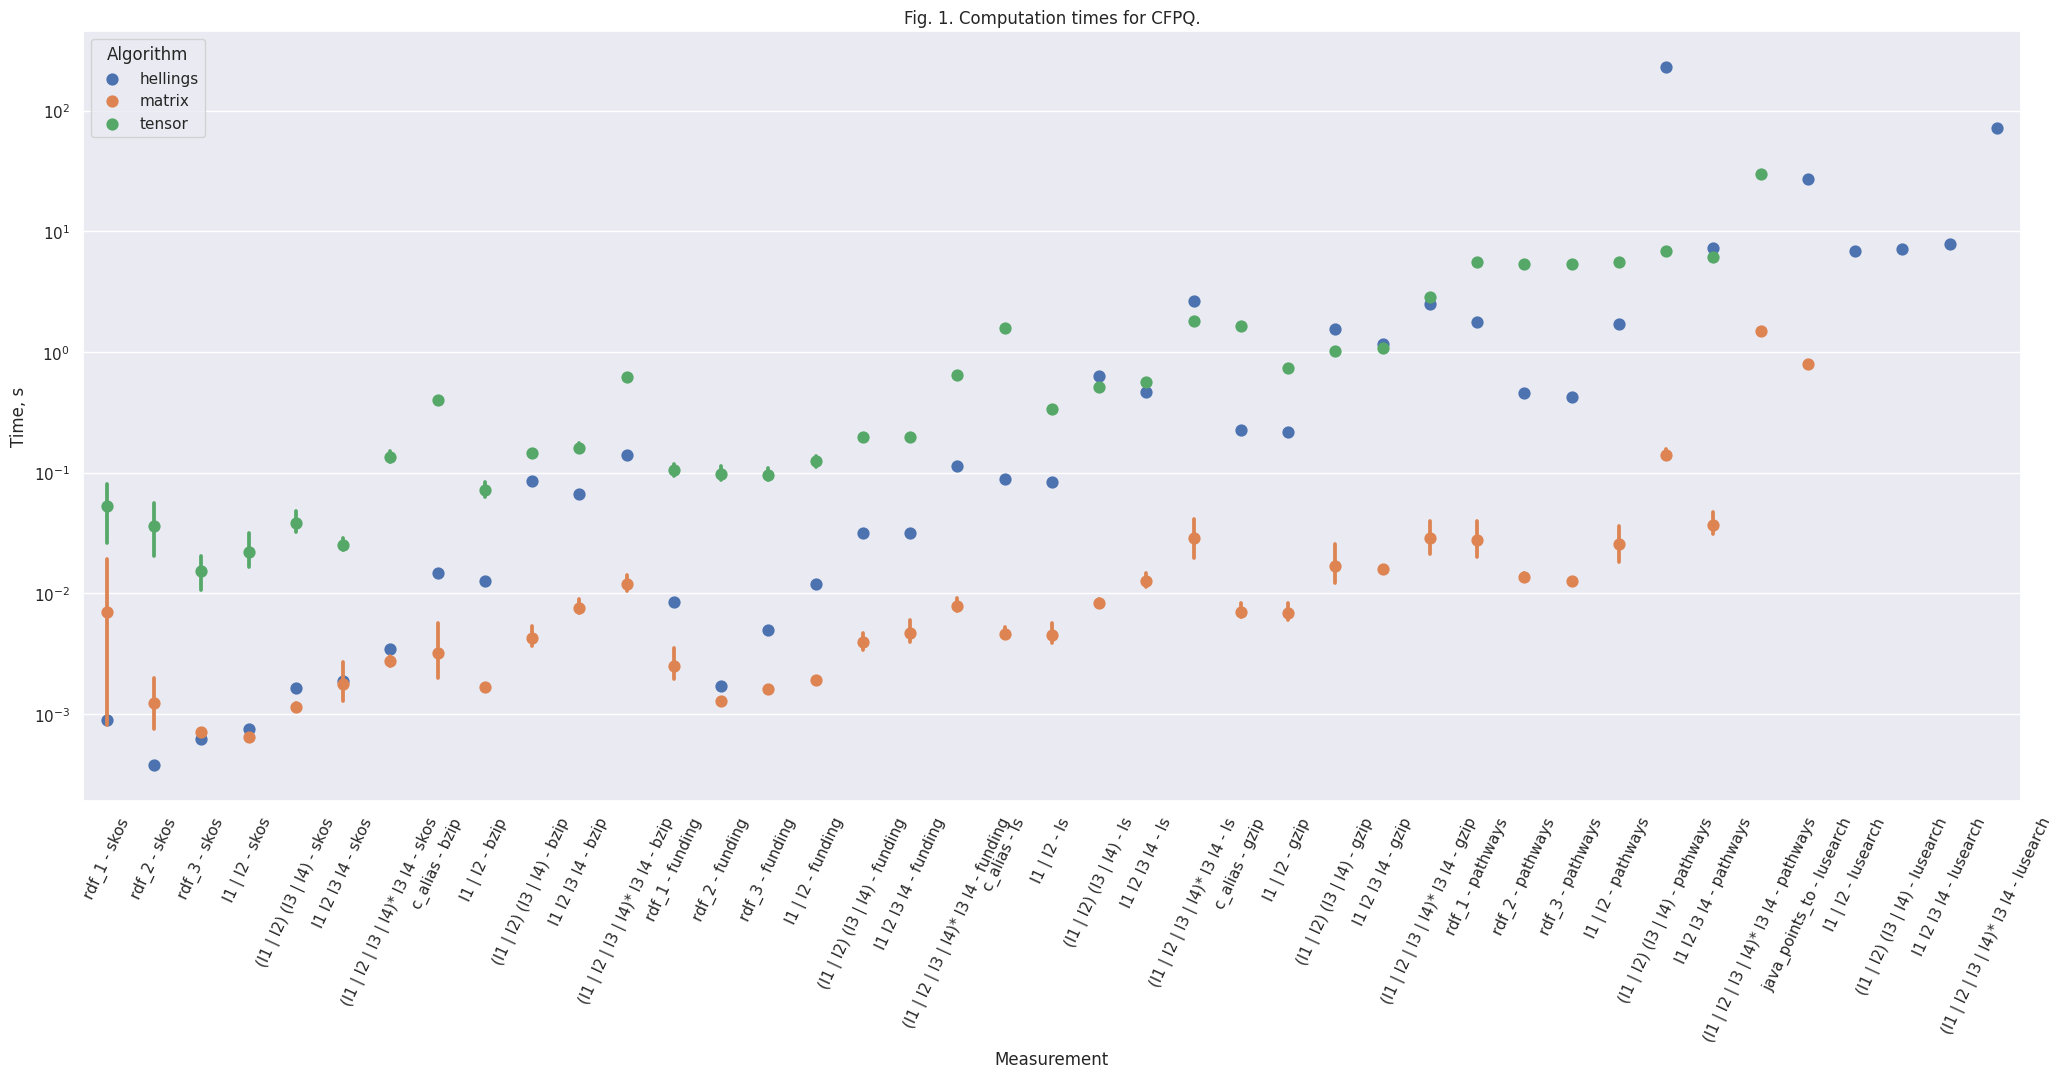

In [194]:
def plot_cfpq_results():
    res = res_to_plot[res_to_plot["Algorithm type"] == "CFPQ"].copy()
    res["Algorithm"] = res["Algorithm"].map(lambda s: s.removesuffix(" (CFPQ)"))

    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time, s",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Fig. 1. Computation times for CFPQ.")
    g.set_xticklabels(g.get_xticklabels(), rotation=65)


plot_cfpq_results()

### Результаты по вопросу 2 (о выгоде от использования специальных алгоритмов для регулярных запросов)

На всех регулярных запросах тензорный алгоритм для регулярных запросов, являющийся, согласно результатам [предыдущей работы](rpq_comparison.ipynb), наиболее быстрым из алгоритмов, специализированных под регулярные запросы, оказался медленнее матричного алгоритма для контекстно-свободных запросов. Сравнение времени работы этих двух алгоритмов продемонстрировано на Рис. 2.

По сравнению с алгоритмом Хеллингса регулярный-тензорный оказывается то быстрее, то медленнее в зависимости от конкретного графа и запроса, однако по сравнению с КС-тензорным регулярный-тензорный алгоритм всегда оказывается быстрее.

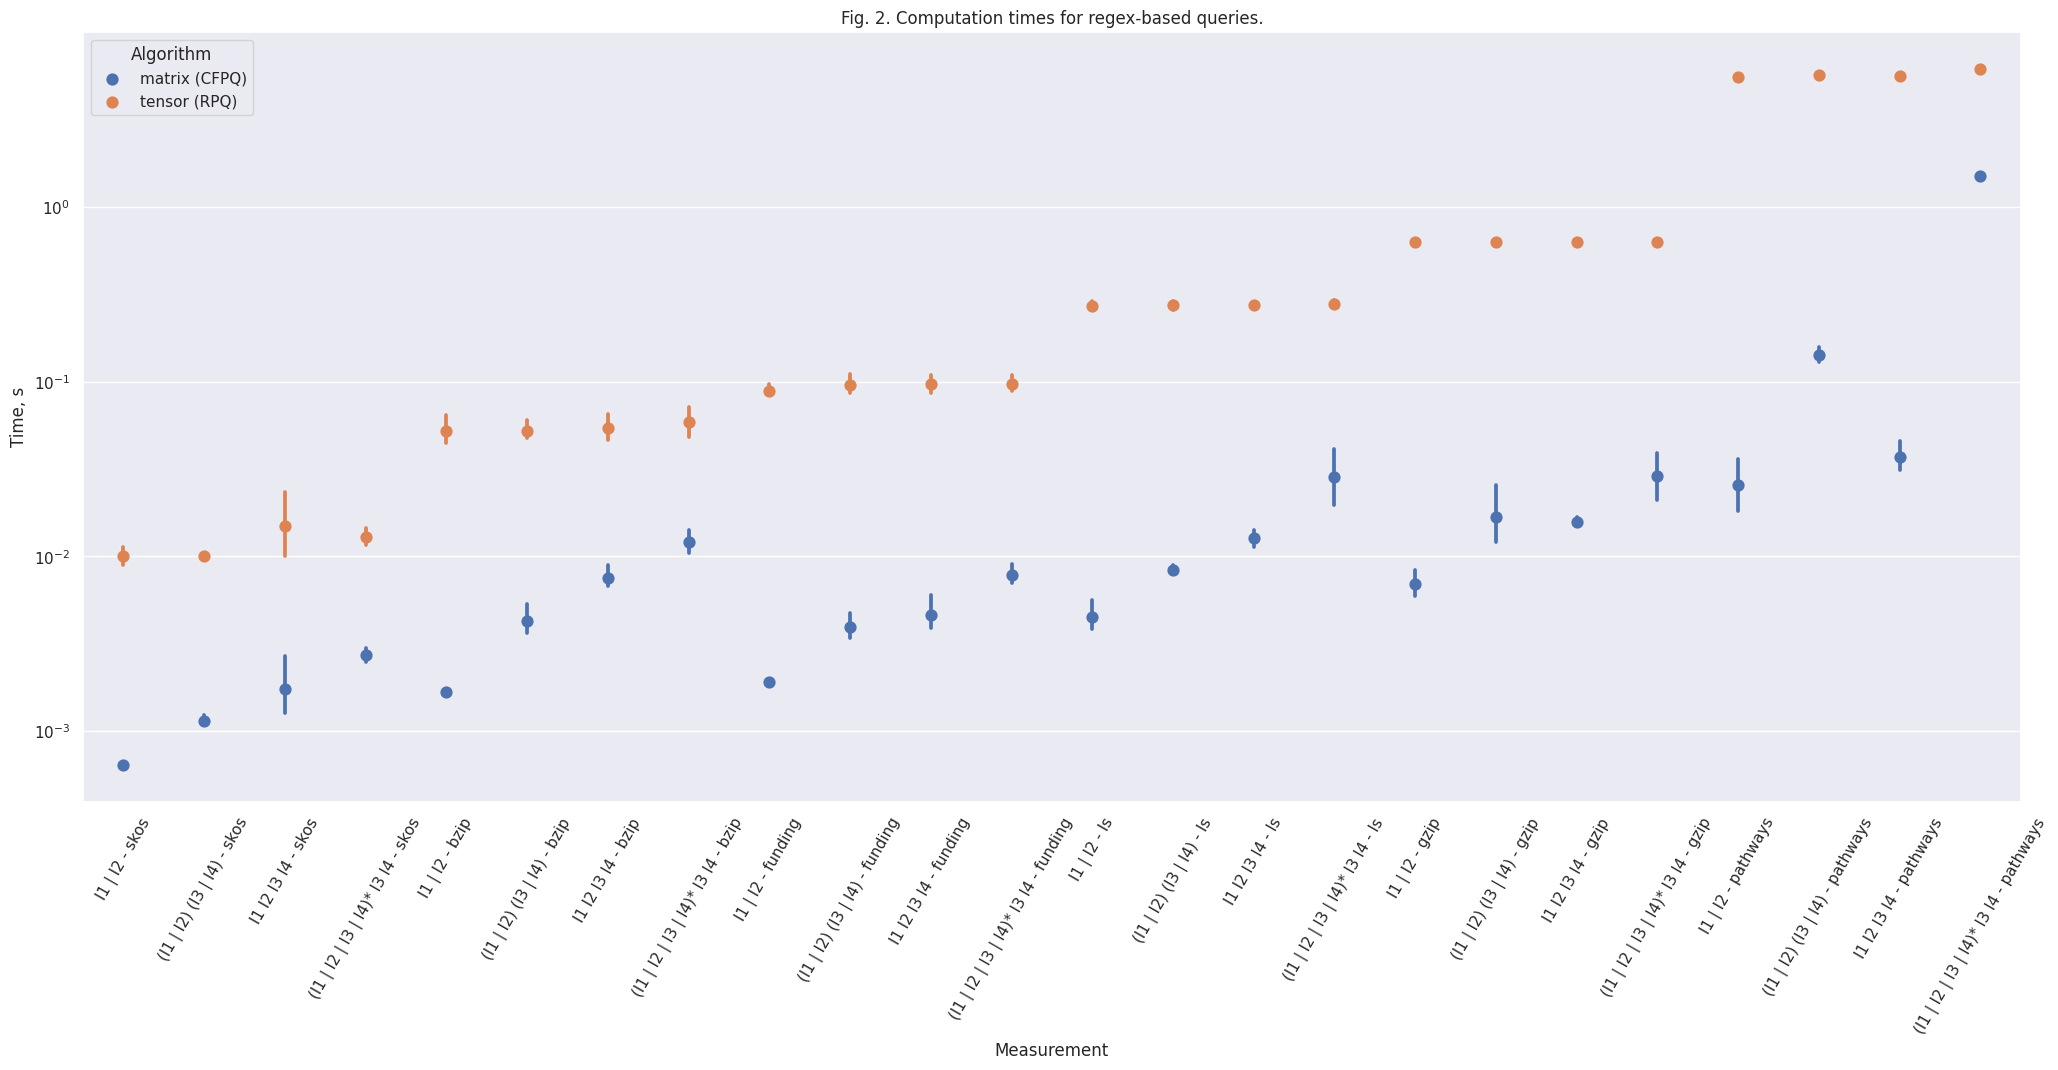

In [195]:
def plot_reg_results():
    res = res_to_plot[
        (res_to_plot["Query type"] == "RPQ") & (res_to_plot["Algorithm"].isin(["matrix", "tensor (RPQ)"]))].copy()
    res["Algorithm"] = res["Algorithm"].map(lambda s: s + " (CFPQ)" if s == "matrix" else s)

    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time, s",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Fig. 2. Computation times for regex-based queries.")
    g.set_xticklabels(g.get_xticklabels(), rotation=60)


plot_reg_results()

## Заключение

В ходе работы были получены следующие результаты относительно рассмотренных реализаций алгоритмов для решения задачи достижимости с контекстно-свободными ограничениями:

1. Наиболее эффективным по скорости работы является реализация матричного алгоритма. Однако, она потребляет большое количество видеопамяти (которой, как правило, меньше, чем обычной ОЗУ) из-за чего не может быть запущена на достаточно больших графах (конкретная величина зависит от объема доступной памяти). При этом такие графы всё ещё могут быть обработаны алгоритмом Хеллингса, рассмотренная реализация которого не использует видеопамять.
2. Применение специализированных алгоритмов для регулярных запросов не имеет смысла, так как реализация матричного алгоритма для контекстно-свободных запросов оказывается быстрее и охватывает более широкое множество возможных запросов.

## Приложение

Далее представлены все результаты экспериментов в виде единой таблицы:

In [196]:
def display_results():
    res_to_display = res_raw.drop(columns=["Query type", "Algorithm type"]).groupby(["Graph", "Query", "Algorithm"],
                                                                                    sort=False).mean()
    res_to_display["Time, s"] = res_to_display["Time, s"].map(
        lambda time: "%.1g" % time if time < 1 else str(round(time)))
    pd.set_option("display.max_rows", len(res_to_display))
    print(res_to_display.rename(columns={"Time, s": "Mean time, s"}))
    pd.reset_option("display.max_rows")


display_results()

                                                  Mean time, s
Graph    Query                      Algorithm                 
skos     rdf_1                      hellings            0.0009
                                    matrix               0.007
                                    tensor (CFPQ)         0.05
         rdf_2                      hellings            0.0004
                                    matrix               0.001
                                    tensor (CFPQ)         0.04
         rdf_3                      hellings            0.0006
                                    matrix              0.0007
                                    tensor (CFPQ)         0.02
         l1 | l2                    hellings            0.0007
                                    matrix              0.0006
                                    tensor (CFPQ)         0.02
                                    tensor (RPQ)          0.01
         (l1 | l2) (l3 | l4)        hellings           